In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing
import pickle
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
def parse(s):
    split = s.split(',')
    n = np.zeros(len(split))
    for i in range(len(split)):
        n[i] = float(split[i])
    return n

In [3]:
num_observations = 1268140
with open("demonstrations_10k") as f:
    s_arr = np.zeros((11, num_observations))
    r_arr = np.zeros((1, num_observations))
    a_arr = np.zeros((3, num_observations))
    sprime_arr = np.zeros((11, num_observations))
    
    i = 0

    for l in f:
        if len(l.strip().split(';')) <= 1:
            continue
    
        i += 1
        s, r, a, sp = l.strip().split(';')
        s_arr[:,i] = parse(s)
        r_arr[:,i] = parse(r)
        a_arr[:,i] = parse(a)
        sprime_arr[:, i] = parse(sp)


In [4]:
s_arr = np.swapaxes(s_arr, 0, 1)
r_arr = np.swapaxes(r_arr, 0, 1)
a_arr = np.swapaxes(a_arr, 0, 1)
sprime_arr = np.swapaxes(sprime_arr, 0, 1)

In [5]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(s_arr)

# Used to convert a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(s_arr))

FeatureUnion(n_jobs=None,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [9]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, scaler, featurizer):
        self.model = SGDRegressor(learning_rate="constant")
        # We need to call partial_fit once to initialize the model
        # or we get a NotFittedError when trying to make a prediction
        # This is quite hacky.
        self.scaler = scaler
        self.featurizer = featurizer
        self.model.partial_fit([self.featurize_state(s_arr[0,:])], [0])
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = self.scaler.transform([state])
        featurized = self.featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s):
        """
        Makes value function predictions.
        """
        features = self.featurize_state(s)
        return self.model.predict([features])[0]
    
    def update(self, s, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        features = self.featurize_state(s)
        self.model.partial_fit([features], y)

In [13]:
def td_learning(estimator, num_episodes, discount_factor=0.95):
    
    for episode in range(num_episodes):
        pkl_name = 'estimator%d.pkl' % episode
        sys.stdout.flush()
        for i in itertools.count():
            if i >= s_arr.shape[0]:
                break
            state = s_arr[i,:]
            reward = r_arr[i,:]
            # action not needed for incremental update when we are only learning value function!
            # we have no idea how states transition or how to choose a good state action pair
            # but that's ok :) 
            action = a_arr[i,:]
            next_state = sprime_arr[i,:]
            
            # TD Update
            q_value_next = estimator.predict(next_state)
            
            td_target = reward + discount_factor * q_value_next
            
            # Update the function approximator using our target
            estimator.update(state, td_target)
            
            print("\rStep {} @ Episode {}/{}".format(i, episode + 1, num_episodes), end="")
        
        with open(pkl_name, 'wb') as pkl:
            pickle.dump(estimator, pkl)

In [14]:
estimator = Estimator(scaler, featurizer)

In [ ]:
stats = td_learning(estimator, 30, discount_factor=0.95)

Step 814931 @ Episode 28/300

In [69]:
 with open('estimator_final.pkl', 'wb') as pkl:
    pickle.dump(estimator, pkl)

In [ ]:
with open('estimator.pkl', 'rb') as pkl:
    estimator = pickle.load(pkl)

In [13]:
values = [estimator.predict(s) for s in s_arr[:100000,:]]

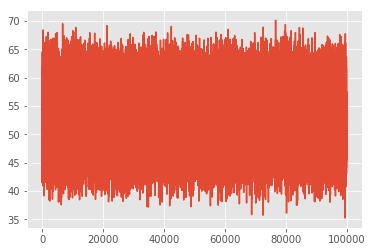

In [14]:
plt.plot(values)

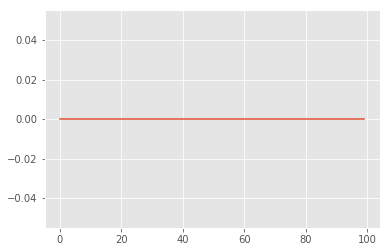

In [12]:
values2 = [estimator.predict(sprime_arr[i]) - estimator.predict(s_arr[i]) for i in range(100000)]
plt.plot(values2)